In [3]:
include("ParRep.jl"); using .ParRep

In [4]:
Base.@kwdef mutable struct GelmanRubinDiagnostic{F}
    observables::F
    means = Matrix{Float64}(undef,1,1)
    sq_means = Matrix{Float64}(undef,1,1)
    burn_in = 10
    tol = 1e-4
    # gr_hist = Float64[]
end

function check_dephasing!(checker::GelmanRubinDiagnostic,replicas::Vector{X},step_n) where {X}
    
    if step_n == 1 # initialize running mean and running square_mean buffer
        checker.means = zeros(length(checker.observables),length(replicas))
        checker.sq_means = copy(checker.means)
    end
    
    @threads for i=1:length(replicas)
        r = replicas[i]
        for (j,f)=enumerate(checker.observables)
            val = f(r)
            sq_val = val^2

            checker.means[j,i] += (val-checker.means[j,i]) / step_n
            checker.sq_means[j,i] += (sq_val-checker.sq_means[j,i]) / step_n

        end
    end

    (step_n < checker.burn_in) && return false

    Obar = sum(checker.means;dims = 2) / length(replicas)

    numerator = sum(@. (checker.sq_means -2checker.means*Obar + Obar^2);dims=2)
    denominator = sum(checker.sq_means - checker.means .^ 2;dims=2)

    R = maximum(numerator ./ denominator) - 1
    # push!(checker.gr_hist,R)
    return (R < checker.tol)
end


In [126]:
Base.@kwdef mutable struct SteepestDescentState{X}
    η = 0.1
    dist_tol = 1e-2
    grad_tol = 1e-3
    steps = 100
    minima = X[]
    ∇V::Function
end

function get_state!(checker::SteepestDescentState,state::X,traj_hist=nothing) where {X}
    x = copy(state)
    grad_norm = Inf
    for k=1:checker.steps
        (traj_hist !== nothing) && push!(traj_hist,x)
        grad = checker.∇V(x)
        x -= checker.η * grad # gradient descent step

        for (i,m)=enumerate(checker.minima)
            dist = √sum(abs2,m-x)
            if dist < checker.dist_tol
                return i
            end
        end

        grad_norm = √sum(abs2,grad)
        (grad_norm < checker.grad_tol) && break
    end

    if grad_norm < checker.grad_tol
        push!(checker.minima,x)
        return length(checker.minima)
    else
        return nothing
    end
end

get_state! (generic function with 2 methods)

In [36]:
const A = [-200,-100,-170,15]
const a = [-1,-1,-6.5,0.7]
const b = [0,0,11,0.6]
const c = [-10,-10,-6.5,0.7]
const x0 = [1,0,-0.5,-1]
const y0 = [0,0.5,1.5,1]

4-element Vector{Float64}:
 0.0
 0.5
 1.5
 1.0

In [115]:
mueller_brown(x,y) = sum(@. A*exp(a*(x-x0)^2 + b*(x-x0)*(y-y0)+c*(y-y0)^2))
mueller_brown(X) = mueller_brown(X...)

function grad_mueller_brown(x,y)
    v = @. A*exp(a*(x-x0)^2 + b*(x-x0)*(y-y0)+c*(y-y0)^2)
    return [sum(@. (2a*(x-x0)+b*(y-y0))*v), sum(@. (2c*(y-y0)+b*(x-x0))*v) ]
end

grad_mueller_brown(X) = grad_mueller_brown(X...)
grad_mueller_brown(0,0)

2-element Vector{Float64}:
 -120.44528523713869
 -108.79148986312214

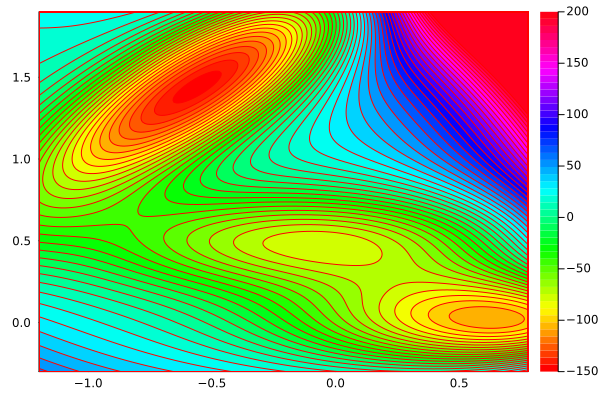

In [116]:
using Plots

xlims = -1.2,0.78
ylims = -0.3,1.9

xrange = range(xlims...,200)
yrange = range(ylims...,200)
contourf(xrange,yrange,mueller_brown,levels=50,clims=(-150,200),cmap=:hsv)

In [123]:
gradient_descender = SteepestDescentState{Vector{Float64}}(η=1e-4,∇V = grad_mueller_brown,steps=500)

for i=1:40
    x_init = rand(xrange)
    y_init = rand(yrange)
    traj_hist = [[x_init,y_init]]
    get_state!(gradient_descender,[x_init,y_init],traj_hist)

    xs=[x[1] for x in traj_hist]
    ys=[x[2] for x in traj_hist]

    plot!(xs,ys,color=:black,label="")
end

1
2
3


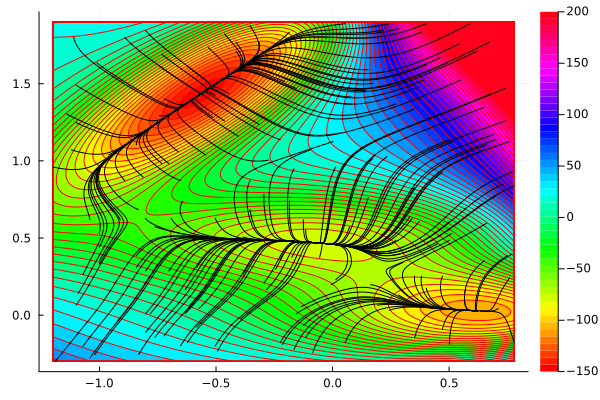

In [124]:
plot!()

In [125]:
gradient_descender.minima

3-element Vector{Vector{Float64}}:
 [0.6234976857958918, 0.028037867161225714]
 [-0.5582252389009602, 1.441724235997671]
 [-0.050006441484435005, 0.4666935688465769]